Here we will investigate posterior estimates of a hierarchical linear regression model using various federated learning frameworks and comparing the quality of posterior estimates to centralised inference using sampling and stochastic variational inference methods.

## Hierarchical linear regression
We will start with the following linear regression example. Each node $n$ has collected a local dataset $\mathcal{D}_n$ of size $K_n = |\mathcal{D}_n|$. Each data set consists of input-output pairs $\mathcal{D}_n  = \left\{ (\pmb{x}^n_k, y^n_k)| \forall k \in \{1, \ldots, K_n\} \right\}$ where $\pmb{x}^n_k \in \mathbb{R}^{D}$, and $\pmb{y}^n_k \in ℝ$. We will assume the following generative model of the data

\begin{equation}
    \begin{split}
        \tau &\sim p(\tau|\tau_0) \\ 
        \lambda_i &\sim \mathcal{C}^+(0, \tau), \:\: \text{for } i \in \{1, \ldots, D\} \\
        \eta_{n,i} &\sim \mathcal{C}^+(0, \lambda_i), \:\: \text{for } n \in \{1, \ldots, N\} \\
        c_n^{-2} &\sim \Gamma(2, 2) \\
        \tilde{\eta}_{n, i}^2 &= \frac{c_n^2}{c_n^2 + \eta_{n, i}^2} \\
        \pmb{\beta}_{n,i} &\sim \mathcal{N}\left(0, \sigma_n^2 \tilde{\eta}_{n,i}^2 \right) \\
        y_n &\sim \mathcal{N} \left( \pmb{\beta}_n \cdot \pmb{x}^n, \sigma_n^2 \right)
    \end{split}
\end{equation}

In [1]:
from jax import lax, vmap, random
from numpyro import sample, plate, deterministic, param
import jax.numpy as jnp
import numpyro.distributions as dist
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

from numpyro.infer import Predictive, MCMC, NUTS
from numpyro.handlers import condition, seed, mask
from numpyro import set_platform
from fedbmr.feds import GenerativeModel

set_platform('gpu')

In [2]:
from jax import devices
devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

<AxesSubplot: >

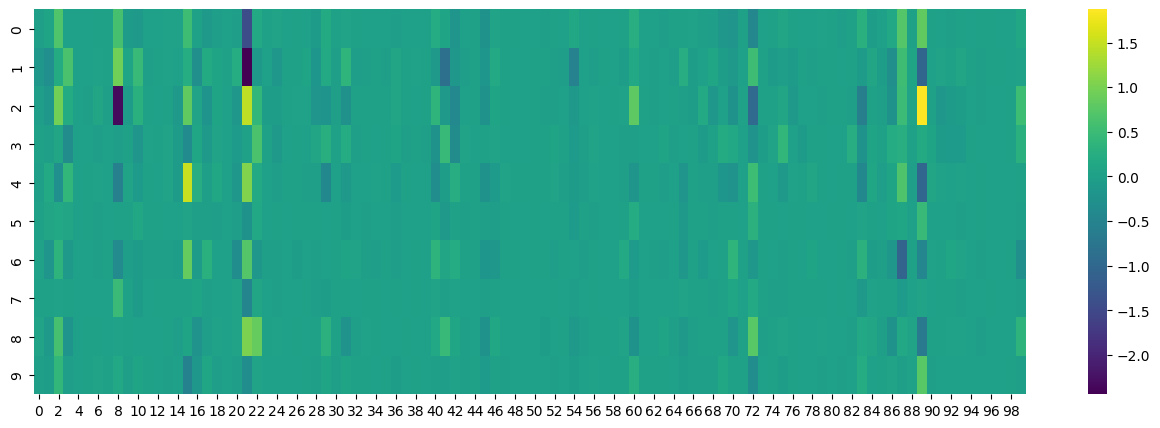

In [3]:
def global_prior(D=100, τ_0=1e-2):
    τ = sample('tau', dist.HalfCauchy(1.))
    with plate('dim', D):
        λ = sample('lambda', dist.HalfCauchy(1.))
    
    params = {
        'global': deterministic('global', τ * λ * τ_0)
    }

    return params

def local_prior(params=None, D=100, N=10):

    with plate('nodes_l', N):
        c = sample('c^{-2}', dist.Gamma(2, 2))
        var = sample('var', dist.Gamma(2, 2))
        eps = sample('eps', dist.Normal(0, 1.).expand([D]).to_event(1))
        # with plate('dim_l', D):
        #     η = sample('eta', dist.HalfCauchy(1.))

    if params is not None:
        η = jnp.expand_dims(params['global'], -1)
    
    tilde_η = jnp.sqrt(η ** 2/(1 + c * η ** 2))
    scale = jnp.sqrt(var)
    beta = (scale * tilde_η).T * eps


    params['local'] = {
        'beta': deterministic('beta', beta), 
        'scale': jnp.sqrt(var)
    }

    return params

vinner = vmap(jnp.inner)

def likelihood(X, params, *, N=10, K=1000, msk=True):
    
    loc = (params['local']['beta'] * X).sum(-1)
    scale = params['local']['scale']
    with mask(mask=msk):
        with plate('nodes_m', N):
            with plate('data', K):
                    sample('y', dist.Normal(loc, scale))

rng_key = random.PRNGKey(101)
rng_key, _rng_key = random.split(rng_key)
N  = 10
D  = 100
K = 100

X = random.normal(_rng_key, shape=(K, N, D))

p = 0.9
msk = random.bernoulli(_rng_key, p, shape=(K, N))

gp = lambda **kwargs: global_prior(D=D, **kwargs)
lp = lambda **kwargs: local_prior(N=N, D=D, **kwargs)
lkl = lambda *args, **kwargs: likelihood(X, *args, N=N, K=K, msk=msk, **kwargs)

gm = GenerativeModel(gp, lp, lkl)

rng_key, _rng_key = random.split(rng_key)
data = Predictive(gm, num_samples=1)(_rng_key)

plt.figure(figsize=(16, 5))
sns.heatmap(data['beta'][0], cmap='viridis')

sample: 100%|██████████| 601/601 [00:29<00:00, 20.45it/s, 63 steps of size 5.90e-02. acc. prob=0.90] 


<AxesSubplot: >

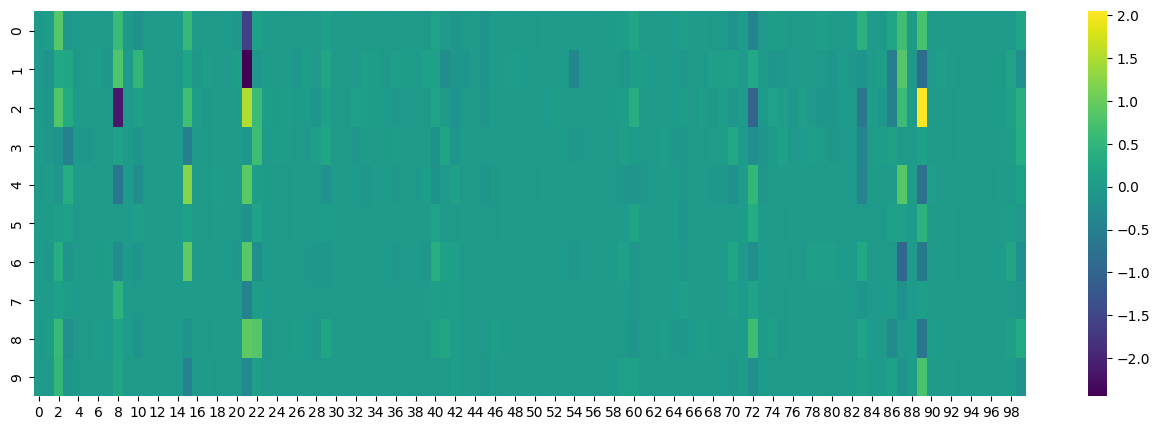

In [4]:
lkl = condition(lkl, data={'y': data['y'][0]})

gm = GenerativeModel(gp, lp, lkl)

kernel = NUTS(gm)
mcmc = MCMC(kernel, num_warmup=500, num_samples=101)

rng_key, _rng_key = random.split(rng_key)
mcmc.run(_rng_key)

smpl = mcmc.get_samples()

plt.figure(figsize=(16, 5))
sns.heatmap(smpl['beta'].mean(0), cmap='viridis')

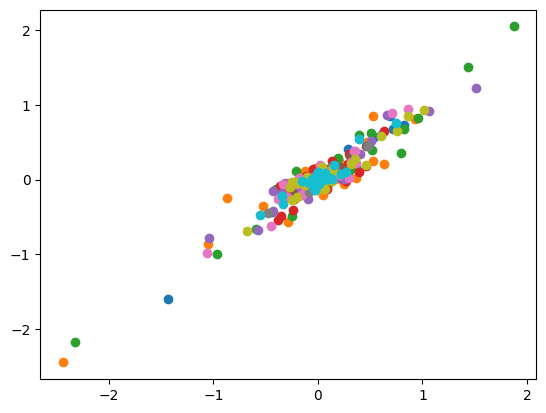

In [5]:
post_beta = smpl['beta'].mean(0)
for n in range(N):
    plt.scatter(data['beta'][0][n], post_beta[n])

In [6]:
def reparam_local_prior(params=None, D=100, N=10):

    with plate('nodes_l', N):
        c = sample('c^{-2}', dist.Gamma(2, 2))
        var = sample('var', dist.Gamma(2, 2))
        eps = sample('eps', dist.Normal(0, 1.).expand([D]).to_event(1))
        with plate('dim_l', D):
            v = sample('v', dist.Gamma(.5, 1.).expand([2]).to_event(1))

    η = deterministic('eta', jnp.sqrt(v[..., 0]/v[..., 1]))

    if params is not None:
        η = η * jnp.expand_dims(params['global'], -1)
    else:
        params = {}
    
    tilde_η = jnp.sqrt(η ** 2/(1 + c * η ** 2))
    scale = jnp.sqrt(var)
    beta = (scale * tilde_η).T * eps


    params['local'] = {
        'beta': deterministic('beta', beta), 
        'scale': jnp.sqrt(var)
    }

    return params

lp2 = lambda *args, **kwargs: reparam_local_prior(*args, N=N, D=D, **kwargs)

In [7]:
lkl = condition(lkl, data={'y': data['y'][0]})

gm2 = GenerativeModel(gp, lp2, lkl)

kernel = NUTS(gm2)
mcmc = MCMC(kernel, num_warmup=500, num_samples=1000)

rng_key, _rng_key = random.split(rng_key)
mcmc.run(_rng_key)

sample: 100%|██████████| 1500/1500 [01:05<00:00, 22.99it/s, 127 steps of size 3.03e-02. acc. prob=0.94]


In [35]:
from optax import adabelief
from numpyro.infer import SVI, TraceGraph_ELBO
from numpyro.infer.autoguide import AutoMultivariateNormal
from numpyro.optim import optax_to_numpyro

def guide(τ_0=1e-2):
    guide1 = AutoMultivariateNormal(gp, prefix='g1')
    out = guide1()

    guide2 = AutoMultivariateNormal(lp2, prefix='g2')
    out['global'] = τ_0 * out['tau'] * out['lambda']
    guide2(out)

lkl = condition(lkl, data={'y': data['y'][0]})

gm2 = GenerativeModel(gp, lp2, lkl)

optim = optax_to_numpyro(adabelief(learning_rate=1e-3))
svi = SVI(gm2, guide,  optim, TraceGraph_ELBO(num_particles=10))
rng_key, _rng_key = random.split(rng_key)
results = svi.run(_rng_key, 25000)

smpl_svi = Predictive(gm2, guide=guide, params=results.params, num_samples=100)(_rng_key)

100%|██████████| 25000/25000 [01:22<00:00, 301.66it/s, init loss: 13000.8115, avg. loss [23751-25000]: 2530.0010]


In [81]:
def log_normal(name, shape):
    loc = param(name + '.loc', jnp.zeros(shape))
    scale = param(name + '.scale', jnp.ones(shape)/10, constraint=dist.constraints.softplus_positive)
    return dist.LogNormal(loc, scale)

def gamma(name, shape):
    a = param(name + '.a', 2*jnp.ones(shape), constraint=dist.constraints.softplus_positive)
    b = param(name + '.b', 2*jnp.ones(shape), constraint=dist.constraints.softplus_positive)
    return dist.Gamma(1. + a, 1. + b)

def local_guide(params=None, D=100, N=10):
    with plate('nodes_l', N):
        c = sample('c^{-2}', log_normal('c^{-2}', (1,)))
        var = sample('var', log_normal('var', (1,)))
        with plate('dim_l', D):
            v = sample('v', gamma('v', (2,)).to_event(1))

        η = deterministic('eta', jnp.sqrt(v[..., 0]/v[..., 1]))

        if params is not None:
            η = η * jnp.expand_dims(params['global'], -1)
        else:
            params = {}
        
        tilde_η = jnp.sqrt(η ** 2/(1 + c * η ** 2))
        scale = jnp.sqrt(var)

        scale = (scale * tilde_η).T

        loc = param('eps.loc', jnp.zeros((N, D)))
        scale_tril = param('eps.scale', jnp.stack([jnp.eye(D)]*N, 0), constraint=dist.constraints.scaled_unit_lower_cholesky)
        eps = sample('eps', dist.MultivariateNormal(loc/scale, scale_tril=scale_tril))

In [82]:
from fedbmr.feds import BMRFed
from numpyro.infer.autoguide import AutoMultivariateNormal, AutoNormal

lkl = condition(lkl, data={'y': data['y'][0]})

bmrfed = BMRFed(gp, lp2, lkl)
# guide = AutoNormal(bmrfed.local_prior)

rng_key, _rng_key = random.split(rng_key)
results = bmrfed.inference(_rng_key, local_guide, num_steps=25_000)

smpl_bmr = Predictive(bmrfed.model, guide=bmrfed.guide, params=results.params, num_samples=100)(_rng_key)

100%|██████████| 25000/25000 [00:58<00:00, 429.50it/s, init loss: 27224.7480, avg. loss [23751-25000]: 2561.8464]


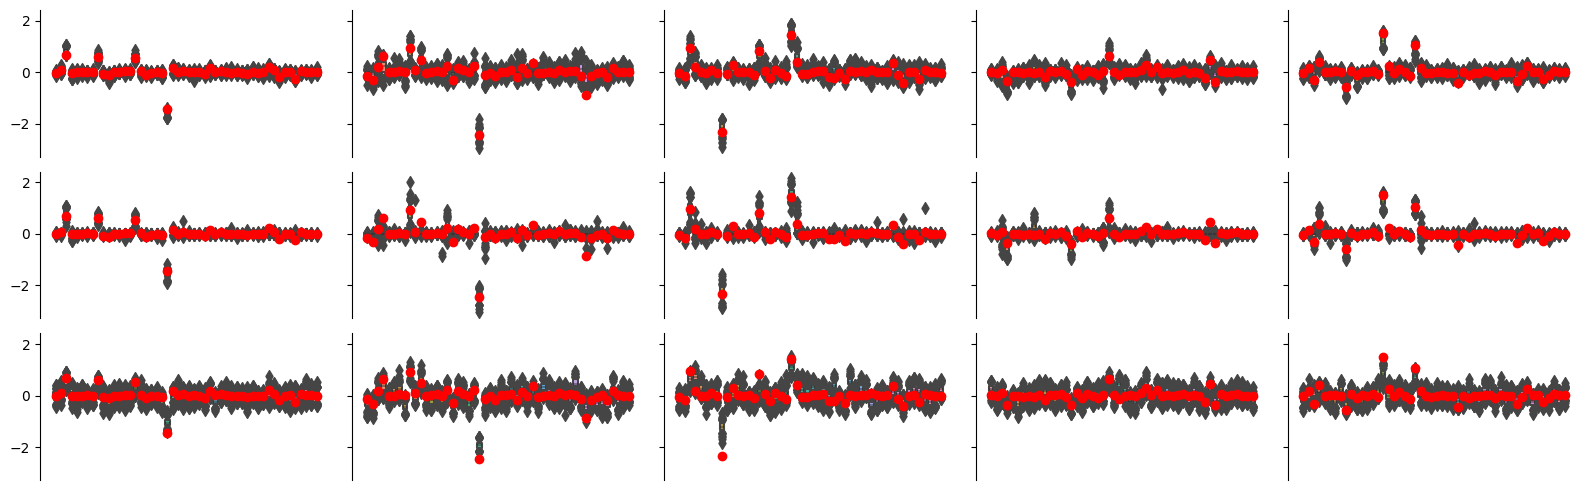

In [83]:
fig, axes = plt.subplots(3, 5, figsize=(16, 5), sharex=True, sharey=True)
for n in range(5):
    sns.boxenplot(smpl_nuts['beta'][:, n, :50], ax=axes[0, n])
    axes[0, n].plot(data['beta'][0, n, :50], 'ro')

    sns.boxenplot(smpl_svi['beta'][:, n, :50], ax=axes[1, n])
    axes[1, n].plot(data['beta'][0, n, :50], 'ro')

    sns.boxenplot(smpl_bmr['beta'][:, n, :50], ax=axes[-1, n])
    axes[-1, n].plot(data['beta'][0, n, :50], 'ro')
    axes[-1, n].set_xticks(ticks=[]);

sns.despine(fig, bottom=True)
fig.tight_layout()